**Import** Libraries

In [1]:
from __future__ import unicode_literals, print_function, division
import numpy as np


**Objective : Design RNN for predicting sequence of characters from training data**

In [2]:
class DataReader:
  def __init__(self):
    self.data = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
    chars = list(set(self.data))
    chars.append(" ")
    self.char_to_ix = {ch:i for (i,ch) in enumerate(chars)}
    self.ix_to_char = {i:ch for (i,ch) in enumerate(chars)}
    self.seq_length = len(self.data)
    self.vocab_size = len(chars)
    #print(self.seq_length)

  def get_inputs_targets(self, data):
   inputs_str = data
   target_str = data[1:] 
   target_str = target_str + " "  
   inputs = [self.char_to_ix[ch] for ch in inputs_str] 
   targets = [self.char_to_ix[ch] for ch in target_str]
   return inputs, targets

datareader = DataReader()
datareader.get_inputs_targets(datareader.data)
print("done")

done


**RNN** **Architecture**
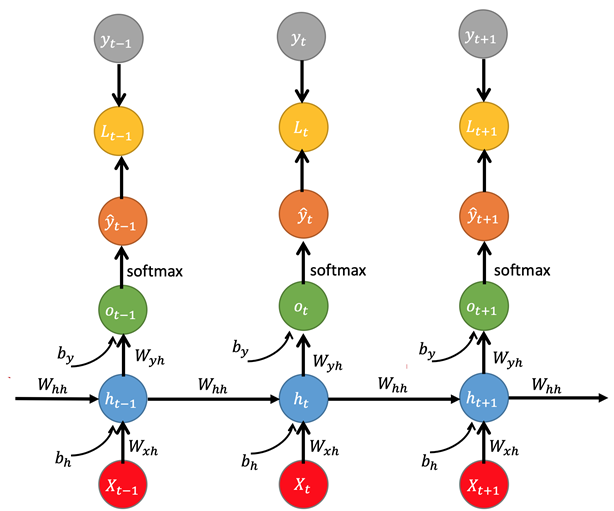

Softmax Modification to control overflow problems: 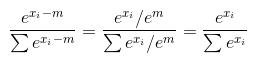

**RNN Forward Pass:**


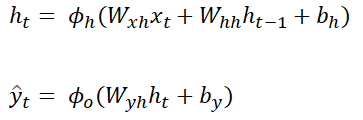

In [98]:

class RNN:
  def __init__(self, hidden_size, vocab_size,seq_length,learning_rate, optimizer="sgd", bias=1):

    self.hidden_size = hidden_size
    self.vocab_size = vocab_size
    self.seq_length = seq_length
    self.learning_rate = learning_rate

    # Model_Parameters
    self.W_xh = np.random.uniform(-np.sqrt(1./vocab_size),np.sqrt(1./vocab_size), size=(hidden_size,vocab_size))
    self.W_hh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(hidden_size,hidden_size))
    self.W_yh = np.random.uniform(-np.sqrt(1./hidden_size),np.sqrt(1./hidden_size), size=(vocab_size,hidden_size))
    self.b_y = np.zeros((vocab_size, 1))
    self.b_h = np.zeros((hidden_size, 1))

    self.optimizer = optimizer
    self.bias = bias

    #Adam variables
    if self.optimizer == 'adam':
      self.beta1 = 0.9
      self.beta2 = 0.999
      self.mt = [np.zeros_like(self.W_xh),
                np.zeros_like(self.W_hh),
                np.zeros_like(self.W_yh),
                np.zeros_like(self.b_y),
                np.zeros_like(self.b_h)]
      self.vt = [np.zeros_like(self.W_xh),
                np.zeros_like(self.W_hh),
                np.zeros_like(self.W_yh),
                np.zeros_like(self.b_y),
                np.zeros_like(self.b_h)]

  
  def softmax(self, x):
    p = np.exp(x-np.max(x))
    return p / np.sum(p)


  def forward(self, inputs,hprev):
    xs, hs, os, ycap = {},{},{},{}
    hs[-1] = np.copy(hprev)
    for t in range(len(inputs)):
      xs[t] = np.zeros((self.vocab_size, 1))
      xs[t][inputs[t]] = 1 # one-hot encoding
      hs[t] = np.tanh(np.dot(self.W_hh,hs[t-1]) + np.dot(self.W_xh,xs[t]) + self.b_h)
      os[t] = np.dot(self.W_yh,hs[t]) + self.b_y
      ycap[t] = self.softmax(os[t])

    return xs, hs, ycap

  def loss(self, ycap, targets):
    return sum(-np.log(ycap[t][targets[t]]) for t in range(self.seq_length))

  def backward(self, xs, hs, ycap,targets):
    dW_xh = np.zeros_like(self.W_xh)
    dW_hh = np.zeros_like(self.W_hh)
    dW_yh = np.zeros_like(self.W_yh)
    db_y = np.zeros_like(self.b_y)
    db_h = np.zeros_like(self.b_h)

    dhnext = np.zeros_like(hs[0])

    for t in reversed(range(self.seq_length)):
      d_yy_cap = np.copy(ycap[t])
      d_yy_cap[targets[t]]-= 1
      dW_yh += np.dot(d_yy_cap,hs[t].T)

      dL_dh = np.dot(self.W_yh.T,d_yy_cap) + dhnext
      dL_dh_dtanh = (1 -hs[t]*hs[t])*dL_dh

      dW_hh += np.dot(dL_dh_dtanh, hs[t-1].T)
      dW_xh += np.dot(dL_dh_dtanh, xs[t].T)
      db_y += d_yy_cap
      db_h += np.dot(dL_dh_dtanh, 1)
      #db_h += np.dot(self.W_yh.T,d_yy_cap)

      dhnext = np.dot(self.W_hh.T,dL_dh_dtanh)


    return dW_xh, dW_hh, dW_yh, db_y, db_h

  def update_model(self, dW_xh, dW_hh, dW_yh, db_y, db_h, t):
    for i, param, dparam in zip([0,1,2,3,4],
                                [self.W_xh, self.W_hh, self.W_yh, self.b_y, self.b_h],
                                [dW_xh, dW_hh, dW_yh, db_y, db_h]):
      
      
      if self.optimizer == 'adam':
        self.mt[i] = (self.beta1 * self.mt[i]) + ((1 - self.beta1) * dparam)
        self.vt[i] = (self.beta2 * self.vt[i]) + ((1 - self.beta2) * np.power(dparam, 2))

        mt_hat = self.mt[i] / (1 - np.power(self.beta1, t+1))
        vt_hat = self.vt[i] / (1 - np.power(self.beta2, t+1))

        if self.bias == 1:
          param +=  -self.learning_rate * (mt_hat / (np.sqrt(vt_hat) + 1e-04))
        else:
          if i == 3 or i == 4:
            continue
          param +=  -self.learning_rate * (mt_hat / (np.sqrt(vt_hat) + 1e-04))

      else:
        if self.bias == 1:
          param += -self.learning_rate * dparam
        else:
          if i == 3 or i == 4:
            continue
          param += -self.learning_rate * dparam

  def predict(self, data_reader, start_char, predict_len):
    x = np.zeros((self.vocab_size,1))
    ix = datareader.char_to_ix[start_char]
    x[ix] = 1
    indexes=[ix]
    hs = np.zeros((self.hidden_size, 1))
    for t in range(predict_len):
      hs = np.tanh(np.dot(self.W_hh,hs) + np.dot(self.W_xh,x))
      os = np.dot(self.W_yh,hs)
      ycap = self.softmax(os)
      ix = np.random.choice(range(self.vocab_size), p = ycap.ravel()) 
      x = np.zeros((self.vocab_size, 1))
      x[ix]= 1
      indexes.append(ix)
    
    txt = ''.join(data_reader.ix_to_char[i] for i in indexes)
    print(txt, '\n')




**Gradient Backpropgation via Recursion:**

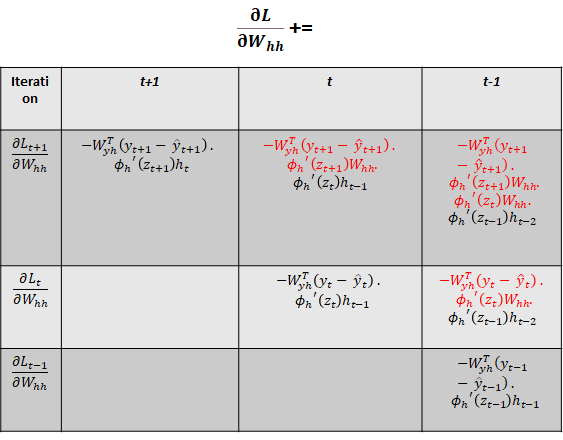

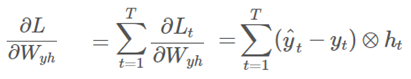

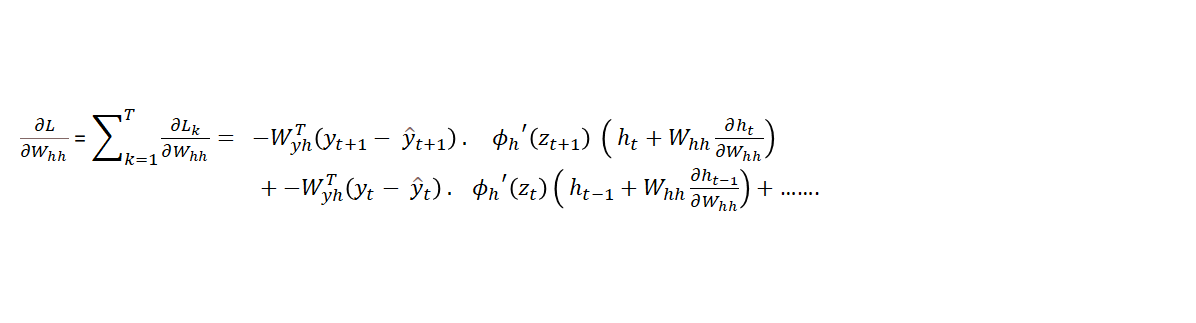

In [94]:
# 1(a). with and without bias training
biases = [0, 1]
bias_dic = {}

for bias in biases:
  print('********************** Bias = ', bias, ' *****************************\n')

  bias_dic[bias] = {'iter' : [], 'loss' : []}
  datareader = DataReader()
  inputs, targets = datareader.get_inputs_targets(datareader.data)

  hidden_size = 10
  lr = 1e-03

  rnn = RNN(hidden_size, datareader.vocab_size, len(inputs), lr, bias=bias)
  loss = 50
  iter = 0
  while(iter < 10001):
    hprev= np.zeros((hidden_size, 1))
    xs, hs , ycap = rnn.forward(inputs,hprev)
    loss = rnn.loss(ycap, targets) 
    dW_xh, dW_hh, dW_yh, db_y, db_h =  rnn.backward(xs, hs, ycap, targets)
    rnn.update_model(dW_xh, dW_hh, dW_yh, db_y, db_h, iter)
    if not iter%1000:
      print("iter num:", iter, ' loss:', loss.item())
      rnn.predict(datareader,'a', rnn.seq_length)
      bias_dic[bias]['iter'].append(iter)
      bias_dic[bias]['loss'].append(loss.item())

    iter += 1


********************** Bias =  0  *****************************

iter num: 0  loss: 257.62892366446454
a5977Tp1d6jt 7FXLCDEF52GvQRwBAqJDfOTmCZhXBdFi2bHtAbM9IytAnZBtmy 

iter num: 1000  loss: 137.37557060161222
aRexG1mnupzVttlpqlFdfpziQhbDeryqY9hVmUrsOrfe6ZtxoCKsgS4hGN8xsVG 

iter num: 2000  loss: 74.3070095849504
aoU3e9mniIeophimnlmtovqHEwABzDEzuBqXE5GNOJKFlTgPgt6BwDsRGHIPEZS 

iter num: 3000  loss: 43.37404625997558
abodefmniykVgnoNkfvqlywryRABChEFesIJ4LSNOrWXS581WP6N6T89 X45Q7  

iter num: 4000  loss: 26.083267048429402
abcJefghoghlmhopelynAmwxyXABCDKLGBI3ELSvODW3u789 J456Te92345S58 

iter num: 5000  loss: 17.28858203339325
abcdefjhiFkoNnopqrstuBUxyzAHCPEFGHIVK5STUVBXOZ012V4RM5UVWXG789  

iter num: 6000  loss: 12.674511701110822
abcdeEgnijkrInopklEzAB2DEFGHIJKLMROPQLMNOPQRSTUV4XY389 345Y56ZY 

iter num: 7000  loss: 9.935419155213047
abcdefghijkfmnopqrstuvwxWtxyzABCDEFGHwJKLMNOPQRSiUxWXYZ01234565 

iter num: 8000  loss: 8.113101079640767
abcdefghiIklmnuvqrsnuZwxyzABCDEFGBg3KLq9234565U

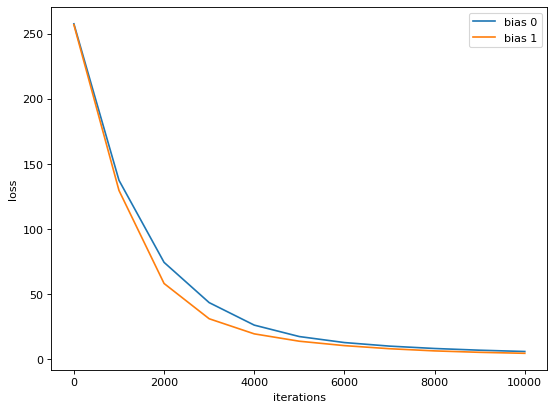

In [97]:
# 1(b). bias visualizations
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

for bias in biases:
  plt.plot(bias_dic[bias]['iter'],bias_dic[bias]['loss'], label='bias '+ str(bias))
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(loc="upper right")

In [117]:
# 2(a). optimizer training
optimizers = ['sgd', 'adam']
optimizer_dic = {}

for optimizer in optimizers:
  print('********************** Optimizer = ', optimizer, ' *****************************\n')

  optimizer_dic[optimizer] = {'iter' : [], 'loss' : []}
  datareader = DataReader()
  inputs, targets = datareader.get_inputs_targets(datareader.data)

  hidden_size = 10
  lr = 1e-03

  rnn = RNN(hidden_size, datareader.vocab_size, len(inputs), lr, optimizer=optimizer)
  loss = 50
  iter = 0
  while(iter < 10001):
    hprev= np.zeros((hidden_size, 1))
    xs, hs , ycap = rnn.forward(inputs,hprev)
    loss = rnn.loss(ycap, targets) 
    dW_xh, dW_hh, dW_yh, db_y, db_h =  rnn.backward(xs, hs, ycap, targets)
    rnn.update_model(dW_xh, dW_hh, dW_yh, db_y, db_h, iter)
    if not iter%1000:
      print("iter num:", iter, ' loss:', loss.item())
      rnn.predict(datareader,'a', rnn.seq_length)
      optimizer_dic[optimizer]['iter'].append(iter)
      optimizer_dic[optimizer]['loss'].append(loss.item())

    iter += 1


********************** Optimizer =  sgd  *****************************

iter num: 0  loss: 257.5273764556903
aivoxcgyifMmAbo8rHoX6 Jw9tlvVdTQRTNr4yZwJyDle9kDnpMUixn0TBS51na 

iter num: 1000  loss: 136.74771190836972
aewdkPRBonIZoJe4ZgypSFIp3zK6u12NQPSRGHIZeZKtsaoBOl1RmlG2qZu1pE6 

iter num: 2000  loss: 63.46755401147931
aFijUfknEVKX9t912vVxynGB1HQPAzUlqrKiu OPCziTABq4wn9891OPyfQPQjk 

iter num: 3000  loss: 35.56250294151799
ab4jw4Wncj9PQ632IVYZKfgNwxCzAVCJkVM6KZM wNyRQTSHUwWr7Z0lMWysZ0W 

iter num: 4000  loss: 22.79982908930422
aAcZ9ijqDmn5pqpstM wTORQRUHkVYXYZs 20VYrztuvwxy0GHIH3 uR7l3D5XY 

iter num: 5000  loss: 16.025712849309823
abctef2612C45p789 M wxSzABCRQzSTU6WrYZM MKwxZzGHIlqL58Yt0 2CJYZ 

iter num: 6000  loss: 12.102727184107035
abcdef5T123L5TU23456W89fwvwRORSTUBGV5Z9LMxwRQRAzSTU2CXYr010dwxQ 

iter num: 7000  loss: 9.621300687799453
aL2defjefgyOr3456789 MvwxbzSHIJmLMNOPQRQHI234oXYZ0A234567Z9 Hvw 

iter num: 8000  loss: 7.918632379058938
abcdefc0723456789 MNwvyzABCDEFGHKlmnopYZ

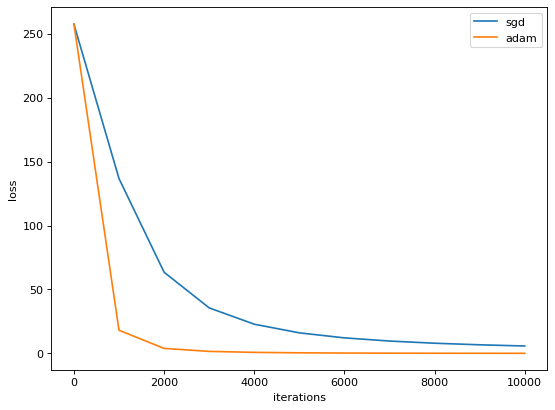

In [118]:
# 2(b). optimizer visualizations
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

for optimizer in optimizers:
  plt.plot(optimizer_dic[optimizer]['iter'],optimizer_dic[optimizer]['loss'], label=optimizer)
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(loc="upper right")

In [115]:
# 3(a). hidden layer size training
layers = [5, 10, 20, 50, 100, 200]
layer_dic = {}

for layer in layers:
  print('********************** Hidden vector size = ', layer, ' *****************************\n')

  layer_dic[layer] = {'iter' : [], 'loss' : []}
  datareader = DataReader()
  inputs, targets = datareader.get_inputs_targets(datareader.data)

  hidden_size = layer
  lr = 1e-03

  rnn = RNN(hidden_size, datareader.vocab_size, len(inputs), lr, optimizer='sgd')
  loss = 50
  iter = 0
  while(iter < 10001):
    hprev= np.zeros((hidden_size, 1))
    xs, hs , ycap = rnn.forward(inputs,hprev)
    loss = rnn.loss(ycap, targets) 
    dW_xh, dW_hh, dW_yh, db_y, db_h =  rnn.backward(xs, hs, ycap, targets)
    rnn.update_model(dW_xh, dW_hh, dW_yh, db_y, db_h, iter)
    if not iter%1000:
      print("iter num:", iter, ' loss:', loss.item())
      rnn.predict(datareader,'a', rnn.seq_length)
      layer_dic[layer]['iter'].append(iter)
      layer_dic[layer]['loss'].append(loss.item())

    iter += 1

********************** Hidden vector size =  5  *****************************

iter num: 0  loss: 257.0594301559806
aLUWmN1fXjM5zIQ W7HyS1hTFHG8G5AXJL5Y9IYClmTUOA7qTuhUgGTaAVGApwz 

iter num: 1000  loss: 184.45483790934477
afJed0GhOez5CwD47FkRefNNWqTRL2NU759gJumxF4ZY8WFOOzYAEfixjzk7Uo4 

iter num: 2000  loss: 137.97935302464748
awcJRsvhp4YYtEMh67Jm9nxOiXcJTn GyI8tDgo66IrldTHij9 L fpqX91mv4w 

iter num: 3000  loss: 113.381866208072
aOVA8FgO3NX0lLv53QGCDLgNPOPqKupx5qrteMo56ids0Mh56sWl0gUiqKl0MfT 

iter num: 4000  loss: 98.6765891054956
aFBX80 w4w6WzADCFGHzADEFjr7smexhirl0SvoVWIdeL3gxyzA8EFqrsZ9 voN 

iter num: 5000  loss: 88.1392402845077
a6z80 nMiyIsZmMUxiXZ8u w5VcsKSvyVWI8lSTU5OIsZSgONPQS34G67AAFEFG 

iter num: 6000  loss: 79.83367082886038
aFE87lSTxpqcdRLgNOPQ0ugNOPje3opGcdRm pVyIdtuvUw6XABCDDDBFDEF5Hc 

iter num: 7000  loss: 72.78652512775925
a4EHGrJKSToVWjA7C jHHzABDCCE45H78fvNxijR0Thwy7klvNhij8A0 2UVq7l 

iter num: 8000  loss: 66.35467405211205
a6I7Zt134GdJ80vfw5yI9tMMNoPQefgh6z8Z 

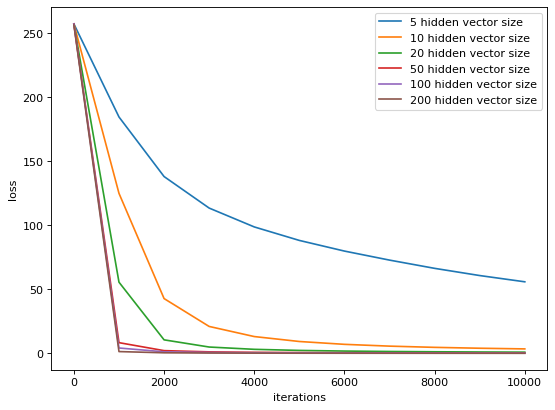

In [116]:
# 3(b). hidden layer sizes visualizations
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

for layer in layers:
  plt.plot(layer_dic[layer]['iter'], layer_dic[layer]['loss'], label=str(layer)+' hidden vector size')
  plt.xlabel('iterations')
  plt.ylabel('loss')
  plt.legend(loc="upper right")